# Chapter: Proximity-based Techniques for Detection


# Topic: Process Fault Detection via KNN

In [15]:
# packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [16]:
# fetch data
import scipy.io

matlab_data = scipy.io.loadmat('MACHINE_Data.mat', struct_as_record = False)
Etch_data = matlab_data['LAMDATA']
calibration_dataAll = Etch_data[0,0].calibration # calibration_dataAll[i,0] corresponds to a 2D data from ith batch where columns correspond to different variables 

variable_names = Etch_data[0,0].variables

In [17]:
# generate unfolded data matrix
n_vars = variable_names.size - 2 # first 2 columns are not process variables
n_samples = 85 # following the work of He et al.

unfolded_dataMatrix = np.empty((1,n_vars*n_samples))
for expt in range(calibration_dataAll.size):
    calibration_expt = calibration_dataAll[expt,0][5:90,2:] # removing first 5 measurements as done in He et al.
    
    if calibration_expt.shape[0] < 85:
        continue
    
    unfolded_row = np.ravel(calibration_expt, order='F')[np.newaxis,:]
    unfolded_dataMatrix = np.vstack((unfolded_dataMatrix, unfolded_row))

unfolded_dataMatrix = unfolded_dataMatrix[1:,:]

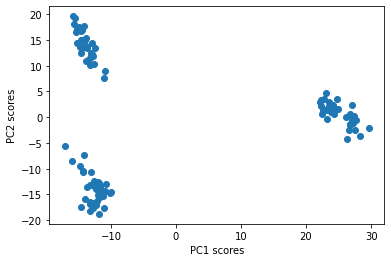

In [18]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#               Fit PCA and use PC scores as model inputs
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# scale data & fit PCA model via pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = 3))])
score_train = pipe.fit_transform(unfolded_dataMatrix)

# visualize in 2D
plt.figure()
plt.scatter(score_train[:,0],score_train[:,1])
plt.xlabel('PC1 scores')
plt.ylabel('PC2 scores')
plt.show()

In [19]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#        k-nearest neighbors of each training sample in score space
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=6).fit(score_train) # a data-point is its own neighbor in training dataset
d2_nbrs, indices = nbrs.kneighbors(score_train)
d2_sqrd_nbrs = d2_nbrs**2
D2 = np.sum(d2_sqrd_nbrs, axis = 1)
D2_log = np.log(D2) 

# Compute D2_log control limit
D2_log_CL = np.percentile(D2_log,95)

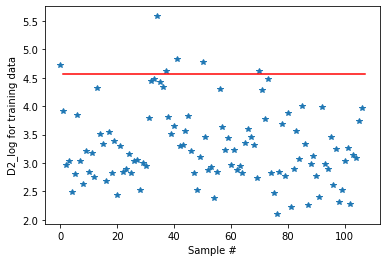

In [20]:
# monitoring chart for training data
plt.figure()
plt.plot(D2_log, '*')
plt.plot([1,len(D2_log)],[D2_log_CL, D2_log_CL], color='red')
plt.xlabel('Sample #')
plt.ylabel('D2_log for training data')
plt.show()

In [21]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#                        test data
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [22]:
# fetch test data and unfold
test_dataAll = Etch_data[0,0].test

unfolded_TestdataMatrix = np.empty((1,n_vars*n_samples))
for expt in range(test_dataAll.size):
    test_expt = test_dataAll[expt,0][5:90,2:]
    
    if test_expt.shape[0] < 85:
        continue
    
    unfolded_row = np.ravel(test_expt, order='F')[np.newaxis,:]
    unfolded_TestdataMatrix = np.vstack((unfolded_TestdataMatrix, unfolded_row))

unfolded_TestdataMatrix = unfolded_TestdataMatrix[1:,:]

# scale and PCA on faulty test data
score_test = pipe.transform(unfolded_TestdataMatrix)


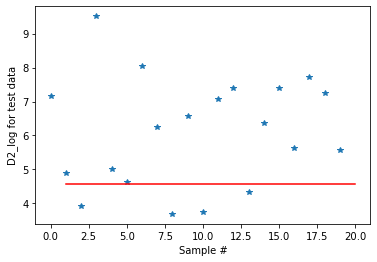

In [23]:
# D2_test
d2_nbrs_test, indices = nbrs.kneighbors(score_test)
d2_nbrs_test = d2_nbrs_test[:,0:5] # we want only 5 nearest  neighbors
d2_sqrd_nbrs_test = d2_nbrs_test**2
D2_test = np.sum(d2_sqrd_nbrs_test, axis = 1)
D2_log_test = np.log(D2_test)

# monitoring chart for test data
plt.figure()
plt.plot(D2_log_test, '*')
plt.plot([1,len(D2_log_test)],[D2_log_CL, D2_log_CL], color='red')
plt.xlabel('Sample #')
plt.ylabel('D2_log for test data')
plt.show()